### Plotting PTMs in Comet, PEAKS DN and PeaksDB results using python for ETNP OM study

Starting with:

    Peaks de novo results of PTM-optimized sequencing
    Comet results from PTM-optimized database searches
    PeaksDB de novo-assisted results from PTM-optimized database searches

Goal:

    Figures comparing the modifcation type and extent in database and de novo peptides
    
Using:

    - pandas
    - matplotlib
    - numpy

In [1]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

### NAAF-corrected residue modification and AA composition across sample set

In [2]:
# for each of the 6 POM samples:
# read in NAAF totals that are combinations of Comet, PeaksDB, and PeaksDN (see NAAF-combination nb)


sum_231 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/NAAF-sums/NAAF-sum-231.csv")
sum_233 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/NAAF-sums/NAAF-sum-233.csv")
sum_243 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/NAAF-sums/NAAF-sum-243.csv")
sum_378 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/NAAF-sums/NAAF-sum-378.csv")
sum_278 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/NAAF-sums/NAAF-sum-278.csv")
sum_273 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/NAAF-sums/NAAF-sum-273.csv")

frames = [sum_231, sum_233, sum_243, sum_378, sum_278, sum_273]
index = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m sink.', '5. 265 m sink.', '6. 965 m sink.']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with sample names
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m sink.', \
         '5. 265 m sink.', '6. 965 m sink']
tot.insert(loc=0, column='sample', value=names)
tot.set_index('sample')

# separate out the dataframe into AAs and %PTMs, too
sum_AA = tot[['sample', 'A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'I-NAAF', 'K-NAAF', \
              'L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', \
              'W-NAAF', 'Y-NAAF']].copy()

sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', 'Gln. w/ deam.', 'Lys. w/ hydr.', \
               'Arg. w/ meth.']].copy()

sum_ptm.columns = ['sample', 'Cysteine w/ carb.', 'Methionine w/ oxidation', 'Asparagine w/ deamidation', \
                   'Glutamine w/ deamidation', \
                   'Lysine w/ oxidation', 'Arginine w/ methylation']

# I think the 'overall modfied' is too biased by terminal residues to be meaningful
#sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', 'Gln. w/ deam.', 'Lys. w/ hydr.', \
               #'Arg. w/ meth.', 'Overall modified']].copy()
    
# Save this df to a csv so I can plot it better
sum_ptm.to_csv('/home/millieginty/Documents/git-repos/2017-etnp/data/thesis-talk/skq17-pom-ptms.csv')

sum_ptm.head()

,sample,Cysteine w/ carb.,Methionine w/ oxidation,Asparagine w/ deamidation,Glutamine w/ deamidation,Lysine w/ oxidation,Arginine w/ methylation
0,1. 100 m sus.,1.0,0.755277,0.117467,0.069276,0.047147,0.052534
1,2. 265 m sus.,1.0,0.165331,0.176517,0.042832,0.060856,0.042856
2,3. 965 m sus.,1.0,0.196061,0.305940,0.054273,0.124276,0.287704
3,4. 100 m sink.,1.0,0.477152,0.237509,0.072189,0.044501,0.471634
4,5. 265 m sink.,1.0,0.665913,0.296353,0.059659,0.173849,0.301735


### 1. Peptide modifications:

<Figure size 720x360 with 0 Axes>

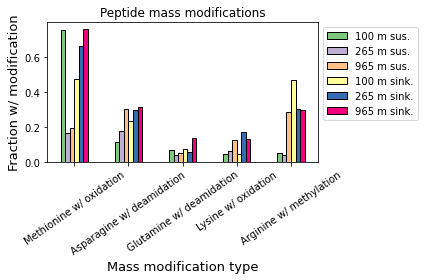

In [3]:
# plot mods across the dataset

sum_ptm_s = sum_ptm.drop(['sample'], axis=1)

ptm_sumT = sum_ptm_s.T

ptm_sumT.columns = ['100 m sus.', '265 m sus.', '965 m sus.', '100 m sink.', '265 m sink.', '965 m sink.']

six_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
six_colors_q = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
seven_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']

fig = plt.figure(figsize = (10, 5)) 

ax = ptm_sumT.iloc[1:7].plot(kind="bar", title = 'Peptide mass modifications', color = seven_colors, edgecolor = 'black')
plt.xticks(rotation=35)

ax.set_ylabel('Fraction w/ modification', fontsize = 13)
ax.set_xlabel('Mass modification type', fontsize = 13)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

plt.tight_layout()

In [4]:
ptm_sumT.head()

,100 m sus.,265 m sus.,965 m sus.,100 m sink.,265 m sink.,965 m sink.
Cysteine w/ carb.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Methionine w/ oxidation,0.755277,0.165331,0.196061,0.477152,0.665913,0.761138
Asparagine w/ deamidation,0.117467,0.176517,0.305940,0.237509,0.296353,0.314271
Glutamine w/ deamidation,0.069276,0.042832,0.054273,0.072189,0.059659,0.135665
Lysine w/ oxidation,0.047147,0.060856,0.124276,0.044501,0.173849,0.130511


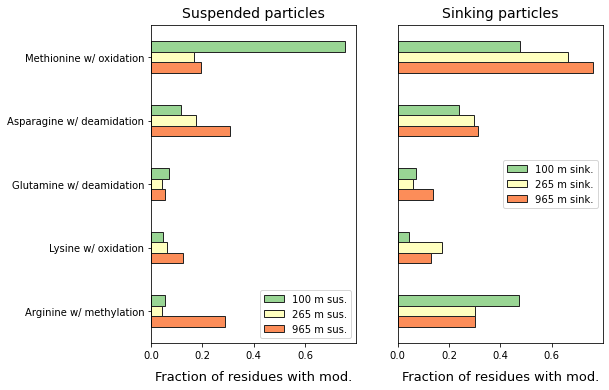

In [5]:
# also plot as subplots of sinking and suspended POM

# df just suspended
sus = ptm_sumT[['100 m sus.', '265 m sus.', '965 m sus.']].copy()
sus = sus.drop('Cysteine w/ carb.', axis=0)
sink = ptm_sumT[['100 m sink.', '265 m sink.', '965 m sink.']].copy()
sink = sink.drop('Cysteine w/ carb.', axis=0)

colors_3 = ['#99d594', '#ffffbf', '#fc8d59']

fig, axes = plt.subplots(figsize=(7, 5),nrows=1, ncols=2, sharex = True)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

sus.plot(ax=axes[0], kind='barh', stacked=False, color = colors_3, edgecolor = '#252525')
sink.plot(ax=axes[1], kind='barh', stacked=False, color = colors_3, edgecolor = '#252525')

axes[0].set_title('Suspended particles', fontsize = 14, pad = 8)
axes[0].invert_yaxis()
axes[0].set_xlabel("Fraction of residues with mod.", fontsize = 13,  labelpad = 10)

axes[1].set_title('Sinking particles', fontsize = 14, pad = 8)
axes[1].set_ylabel("")
axes[1].yaxis.set_ticks([])
axes[1].invert_yaxis()
axes[1].set_xlabel("Fraction of residues with mod.", fontsize = 13, labelpad = 10);

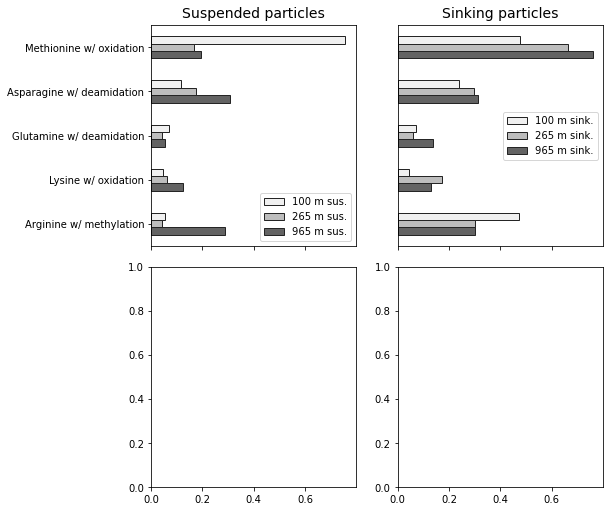

In [6]:
# also plot as subplots of sinking and suspended POM

# df just suspended
sus = ptm_sumT[['100 m sus.', '265 m sus.', '965 m sus.']].copy()
sus = sus.drop('Cysteine w/ carb.', axis=0)
sink = ptm_sumT[['100 m sink.', '265 m sink.', '965 m sink.']].copy()
sink = sink.drop('Cysteine w/ carb.', axis=0)

colors_3 = ['#99d594', '#ffffbf', '#fc8d59']
colors = ['#f0f0f0', '#bdbdbd', '#636363']

fig, axes = plt.subplots(figsize=(7, 7),nrows=2, ncols=2, sharex = True)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

sus.plot(ax=axes[0,0], kind='barh', stacked=False, color = colors, edgecolor = '#252525')
sink.plot(ax=axes[0,1], kind='barh', stacked=False, color = colors, edgecolor = '#252525')

axes[0,0].set_title('Suspended particles', fontsize = 14, pad = 8)
axes[0,0].invert_yaxis()
axes[0,0].set_xlabel("Fraction of residues with mod.", fontsize = 13,  labelpad = 10)

axes[0,1].set_title('Sinking particles', fontsize = 14, pad = 8)
axes[0,1].set_ylabel("")
axes[0,1].yaxis.set_ticks([])
axes[0,1].invert_yaxis()
axes[0,1].set_xlabel("Fraction of residues with mod.", fontsize = 13, labelpad = 10);

In [7]:
# read in the reworked ptms from Excel file I created

ptm = pd.read_excel('/home/millieginty/Documents/git-repos/2017-etnp/data/thesis-talk/skq17-pom-ptms.xlsx')



ptm.head()

,depth,sus meth ox,sink meth ox,sus asp deam,sink asp deam,sus gln deam,sink gln deam,sus lys oxid,sink lys oxid,sus arg meth,sink arg meth
0,100,75.527738,47.715235,11.746655,23.750919,6.927627,7.218938,4.714704,4.450116,5.253375,47.163355
1,265,16.533127,66.591327,17.651726,29.635289,4.283249,5.965871,6.085593,17.384939,4.285572,30.173515
2,965,19.606136,76.113837,30.593951,39.427119,5.427334,13.566455,12.427584,13.051116,28.770450,30.008164


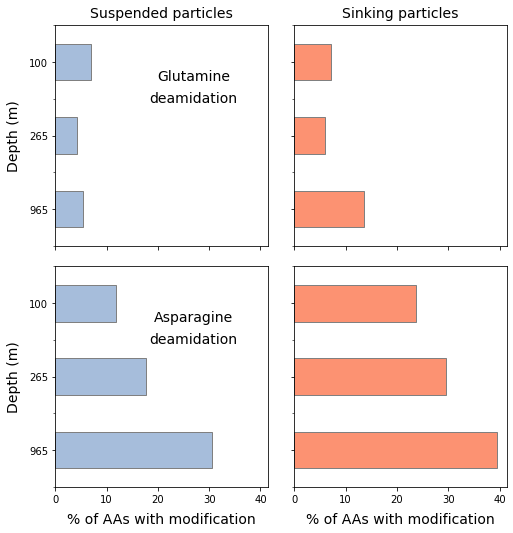

In [16]:
fig, axes = plt.subplots(figsize=(7, 7),nrows=2, ncols=2, sharex = True, sharey = True)

plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

# Suspended methionine oxidation

axes[0,0].set_title('Suspended particles', fontsize = 14, pad = 8)

ptm.plot(ax=axes[0,0], kind='barh', y = 'sus gln deam', x = 'depth', color = '#a6bddb', edgecolor = 'grey')
axes[0,0].set_ylim(axes[0,0].get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
axes[0,0].set_ylabel('Depth (m)', fontsize = 14, labelpad = 8)
axes[0,0].get_legend().remove()

axes[0,0].annotate('Glutamine', xy=(2, 2), 
            xytext=(0.65, 0.8), textcoords='axes fraction',
            color='black', fontsize=14,
            horizontalalignment='center', verticalalignment='top')

axes[0,0].annotate('deamidation', xy=(2, 2), 
            xytext=(0.65, 0.7), textcoords='axes fraction',
            color='black', fontsize=14,
            horizontalalignment='center', verticalalignment='top')

# Suspended asparagine deamidation

ptm.plot(ax=axes[1,0], kind='barh', y = 'sus asp deam', x = 'depth', color = '#a6bddb', edgecolor = 'grey')
axes[1,0].set_ylim(axes[0,0].get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
axes[1,0].set_ylabel('Depth (m)', fontsize = 14, labelpad = 8)
axes[1,0].get_legend().remove()

axes[1,0].annotate('Asparagine', xy=(2, 2), 
            xytext=(0.65, 0.8), textcoords='axes fraction',
            color='black', fontsize=14,
            horizontalalignment='center', verticalalignment='top')

axes[1,0].annotate('deamidation', xy=(2, 2), 
            xytext=(0.65, 0.7), textcoords='axes fraction',
            color='black', fontsize=14,
            horizontalalignment='center', verticalalignment='top')

axes[1,0].set_xlabel('% of AAs with modification', fontsize = 14, labelpad = 8)


# Sinking methionine oxidation

axes[0,1].set_title('Sinking particles', fontsize = 14, pad = 8)

ptm.plot(ax=axes[0,1], kind='barh', y = 'sink gln deam', x = 'depth', color = '#fc9272', edgecolor = 'grey')
axes[0,1].set_ylim(axes[0,1].get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
#axes[0,1].set_ylabel('', fontsize = 14, labelpad = 8)
axes[0,1].get_legend().remove()

#axes[0,1].annotate('Methionine', xy=(2, 2), 
            #xytext=(0.80, 0.2), textcoords='axes fraction',
            #color='black', fontsize=14,
            #horizontalalignment='center', verticalalignment='top')

#axes[0,1].annotate('oxidation', xy=(2, 2), 
            #xytext=(0.82, 0.1), textcoords='axes fraction',
            #color='black', fontsize=14,
            #horizontalalignment='center', verticalalignment='top')
            
# Sinking asparagine deamidation

ptm.plot(ax=axes[1,1], kind='barh', y = 'sink asp deam', x = 'depth', color = '#fc9272', edgecolor = 'grey')
axes[1,1].set_ylim(axes[1,1].get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
axes[1,1].set_ylabel('Depth (m)', fontsize = 14, labelpad = 8)
axes[1,1].get_legend().remove()

#axes[1,1].annotate('Asparagine', xy=(2, 2), 
            #xytext=(0.65, 0.2), textcoords='axes fraction',
            #color='black', fontsize=14,
            #horizontalalignment='center', verticalalignment='top')

#axes[1,1].annotate('deamidation', xy=(2, 2), 
            #xytext=(0.65, 0.1), textcoords='axes fraction',
            #color='black', fontsize=14,
            #horizontalalignment='center', verticalalignment='top')

axes[1,1].set_xlabel('% of AAs with modification', fontsize = 14, labelpad = 8);

fig.savefig('/home/millieginty/Documents/git-repos/2017-etnp/data/thesis-talk/entp-mod.png', facecolor=fig.get_facecolor(), transparent=True, dpi=300, bbox_inches = "tight")